In [1]:
#Version 1 Jianfeng (Danny) Guo 11/2024
import numpy as np 
import os 
import matplotlib.pyplot as plt
import os.path
import skimage.io as io
from math import floor, ceil, exp
import tkinter.filedialog as fd
import skimage as si
from scipy.io import savemat, loadmat
import tkinter as tk
from skimage.feature import blob_log, blob_doh, blob_dog
from skimage.restoration import rolling_ball
from skimage import transform, img_as_int, exposure
from scipy import ndimage, spatial

C:\Users\24958\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
#check whether this has coordinate problem when producing CM
def poly_transf():
    """This function is used for uploading the polynomial transformation which defines the relation between Green and Red channels

    Args:
        base_path (string): The absolute path of the input files.
       
    Returns:
        tr_G2R: forward transformation (it describes transformation from green to red channel),
        tr_R2G: reverse transformation (it describes transformation from red to green channel)
    """
    tr_G2R = transform.PolynomialTransform()
    file_path = fd.askopenfilename(title = "Choose the forward transform file (Green to Red)")
    tr_G2R.params = np.load(file_path)
    tr_R2G = transform.PolynomialTransform()
    file_path = fd.askopenfilename(title = "Choose the inverse transform file (Red to Green)")
    tr_R2G.params = np.load(file_path) 
    return (tr_G2R, tr_R2G)

def align_2channels(img,tr_R2G,rb_rad, r,ALEX = True,thr=300):
        """
        This function is creating the .mat files containing matched smFRET traces and sequences for molecules from FOVs that were aligned in the previous step

        Args:
        img- the input is a movie
        ALEX (boolean): Was imaging performed with alternating laser excitation (ALEX)?.
        tr_R2G : forward transformation mapping Cy3 and Cy5 channels
        tr: smFRET image threshold, 300 by default
        Returns:
        rb_rad - rolling ball radius
        r - Half-width of the molecule aperture for trace extraction, i.e. for r = 3 it is -3:3
        "time": time information from smFRET trace 
        "Cy3": Cy3 intensity 
        "Cy5": Cy5 intensity 
        "Dist": distance betweeen a cluster and a corresponding single molecule,
        "x": x coordinates of single mol0[-p]=p==-0pecules from the Cy5 channel,
        "y": y coordinates of single molecules from the Cy5 channel,

          
    
    
        """
        #import tif file and check whether they are taken in ALEX (usually are)
        # Averaging the first 10 frames to select peaks
        if ALEX:
            green_frames = np.add(1,np.multiply(2,range(10)))
            red_frames = np.subtract(green_frames,1)
            img_t = np.mean(img[red_frames,::], axis = 0) #average over all red frame
        else:
            img_t = np.mean(img[0:10,::], axis = 0) #average over all first 10 frame        
        img_t = img_t.astype("ushort")

    # align the red and green channel and combine the image together for further process
    # no blue so each pixels has two value
        red = img_t[256:,:] #upper half of tif file is the red channel
        green = img_t[:256,:] #lower half of tif file is the green channel
        #use  rolling ball subtract the background
        red = red - rolling_ball(red,radius = rb_rad) 
        green = green - rolling_ball(green,radius = rb_rad)
        green = transform.warp(green,tr_R2G, preserve_range = True) #Use the bead file for channel alignment green to red
        flag = True
        if ALEX:
            combined = []
            for e in range(len(red)):
            #you need to change every element in red from int to float otherwise blob_log function wouldnt work (for some reason)
                combined.append(np.array(list(map(float, red[e]))))
            combined = np.array(combined)
 #Nothing in green channel
        else:
            combined = red + green # since it is two separate channel just combine the array to enhance the signal from molecules.


        #choose the threshold for bolb detection to identify the fluorophores inside the image
        while flag:
                thr = int(input("Please, choose the treshold, default value 300: "))
                fig, ax = plt.subplots()
                ax.imshow(combined)
                blobs_log = blob_log(combined, max_sigma=10, num_sigma=10, threshold=thr)
                CM = [] #record the centre of mass of every blob(detected molecu;ar)
                [h,w] = red.shape
                n_frames = img.shape[0]

                for i, blob in enumerate(blobs_log):
                    x, y, d = blob
                    if x>r and x<(h-r) and y>r and y<(w-r):
                        #set a condition for buffer region (20 pixel from the edge) so that we do not choose the blob at the edges (can cause problem)
                        if x>20 and x<(h- 20) and y>20 and y<(w-20):
                            temp = ndimage.measurements.center_of_mass(combined[int(x-r):int(x+r+1),int(y-r):int(y+r+1)])
                            CM.append(np.flip(np.add(temp, [x-r,y-r])))

                            c = plt.Circle(CM[-1], 3, color="red", linewidth=1, fill=False)
                            ax.add_patch(c)
                ax.set_axis_off()

                plt.show()

                check = input("Please type y if threshold is good enough: ").lower()
                if check == "y":
                    flag = False 
    #Here we have the centre of mass of the molecules in the red channel    
        return CM



In [3]:
# image = io.imread("S1_G10H_1mM_10mW_1Hz_Flow40_1_MMStack_Pos0.ome.tif")
# CM = align_2channels(image,tr_R2G,10, 3)

In [15]:
def extract_traces(tr_R2G,tr_G2R,colour = 2,thr = 300,ALEX = True):
    """
    This function is creating the .mat files containing matched smFRET traces and sequences for molecules from FOVs that were aligned in the previous step

    Args:
        img- the input is a movie
        ALEX (boolean): Was imaging performed with alternating laser excitation (ALEX)?.
        tr_R2G : forward transformation mapping Cy3 and Cy5 channels
        thr: smFRET image threshold, 300 by default
    Returns:
        rb_rad - rolling ball radius
        r - Half-width of the molecule aperture for trace extraction, i.e. for r = 3 it is -3:3
        "time": time information from smFRET trace 
        "Cy3": Cy3 intensity 
        "Cy5": Cy5 intensity 
        "Dist": distance betweeen a cluster and a corresponding single molecule,
        "x": x coordinates of single mol0[-p]=p==-0pecules from the Cy5 channel,
        "y": y coordinates of single molecules from the Cy5 channel,

          
    
    
    """


    rb_rad = int(input("Please enter the radius for the rolling ball background estimation, put 10 as a default "))
    rb = int(rb_rad/2) # Half-width of the background aperture for trace extraction
    r = int(input("Please enter the half-width of the molecule aperture for trace extraction, , i.e. for r = 3 it is -3:3"))
    root = tk.Tk()
    root.attributes("-topmost", True)
    root.withdraw()

    path = fd.askdirectory(title = "Choose the directory containing smFRET image", initialdir = "C:/Users/Anton/Documents/Jupyter home/ExampleData/Test_folder/220717_FC_Nano_200nm_Multicolor/original")
    os.chdir(path)
    
    for current_dir,dirs, files in os.walk(path) :
        for el in files: 
            if el.split('.')[-1].lower() == 'tif':
                img_smFRET = io.imread(el)
                n_frames = len(img_smFRET)
                frame_rate = int(input("Please, choose the frame rate(Hz) "))
                rb = int(rb_rad/2)
                #define a square apreture around the molecules for background calculation later
                at = [[j,i] for i in range(2*rb+1) for j in range(rb-r)]
                bt = [[j,i] for i in range(2*rb+1) for j in range(r+rb+1,2*rb+1)]
                ct = [[j,i] for i in range(rb-r) for j in range(rb-r,r+rb+1)]
                dt = [[j,i] for i in range(r+rb+1,2*rb+1) for j in range(rb-r,r+rb+1)]
                idx_bg = np.subtract(np.concatenate([at,bt,ct,dt]), [rb,rb])
                if colour == 2:
                    red = img_smFRET[1,:int((len(img_smFRET[0])/2)),:]
                    #use align_2channels to generate molecule positions in red images.
                    CM_red = np.array(align_2channels(img_smFRET,tr_R2G,rb_rad,r,ALEX, thr))
                    n_traces = len(CM_red)
                    #the transformation transform green image to red image but coordinate in red image for coordinate in green image, can confuse people
                    CM_green = tr_R2G(CM_red)
                    CM_red = CM_red.tolist()
                    CM_green = CM_green.tolist()
                    flag = True
                    [h,w] = red.shape
                    #put a filter on CM_green to clean out all the molecules that are too close to the edge (same as how CM_red is produced)
                    while flag:
                        #the reason why a while loop is used here is that a for loop operates on indices
                        #if the current element is deleted the next element will shift to current and will get skipped in the for loop check
                        #using a while loop forces for loop to operates multiple time
                        checker = len(CM_green)
                        counter = len(CM_green)
                        for e in CM_green:
                            e = np.array(e)
                            x,y = e
                            if x<=20 or x>=(w-20) or y<=20 or y>=(h-20):
                                print("deleted: "+str(e))
                                idx = CM_green.index((e.tolist()))
                                CM_green.pop(idx)
                                CM_red.pop(idx)
                                counter -= 1
                        if checker == counter:
                            flag = False
                    CM_red= np.array(CM_red)
                    CM_green = np.array(CM_green)
                    if len(CM_green) == len(CM_red):
                        print("red = green")
                    #calculate the weight of molecules and pixel around it at the rate of 2r+1 circle/square
                    weights_red = np.zeros([n_traces,2*r+1,2*r+1])
                    weights_green = np.zeros([n_traces,2*r+1,2*r+1])
                    #initialise traces matrix to store traces in
                    traces_red =  np.zeros([n_traces,n_frames])
                    traces_green = np.zeros([n_traces,n_frames])
                    #the following code applies a gaussian (peak value 1, centred at the molecule) to the molecule and the pixel around to improve SN ratio
                    for  j,coord in enumerate(CM_red):
                            x, y = coord
                            x0 = int(x-r)
                            x1 = int(x+r+1)
                            y0 = int(y-r)
                            y1 = int(y+r+1)
                            dx = x-x0
                            dy = y-y0

                            it = np.nditer(weights_red[j], flags=['multi_index'], op_flags=['readwrite'])
                            for w1 in it:
                                yt,xt = it.multi_index
                                w1[...] = 2*exp(-0.4*((xt-dx)**2+(yt-dy)**2))
                            it.close()

                            x, y = CM_green[j]
                            x0 = int(x-r)
                            x1 = int(x+r+1)
                            y0 = int(y-r)
                            y1 = int(y+r+1)
                            dx = x-x0
                            dy = y-y0
                            
                            it = np.nditer(weights_green[j], flags=['multi_index'], op_flags=['readwrite'])
                            for w1 in it:
                                yt,xt = it.multi_index
                                w1[...] = 2*exp(-0.4*((xt-dx)**2+(yt-dy)**2))
                            it.close()

                   
                    #For both green and red channel, subtract the background (the median of the surrounded dark pixel) and extract the intensity value  
                    for k in range(n_frames):
                        print("Working on frame "+str(k))
                        red1 = img_smFRET[k,int((len(img_smFRET[0])/2)):,:]
                        red1 = red1 - rolling_ball(red1, radius=rb_rad)
                        green1 = img_smFRET[k,:int((len(img_smFRET[0])/2)),:]
                        green1 = green1 - rolling_ball(green1, radius=rb_rad)
                        for j,coord in enumerate(CM_red):
                            x, y = coord
                            x0 = int(x-r)
                            x1 = int(x+r+1)
                            y0 = int(y-r)
                            y1 = int(y+r+1)
                            dx = x-x0
                            dy = y-y0
                            index = np.add(idx_bg,[int(x), int(y)])
                #using the median of the dark pixel values around for a good estimation of the backgrpimd
                            BG = np.median(red1[index[:,1], index[:,0]])
                            red2 = np.subtract(red1[y0:y1,x0:x1], BG)
                            traces_red[j,k] = np.sum(np.multiply(weights_red[j],red2))
                            x, y = CM_green[j]
                            x0 = int(x-r)
                            x1 = int(x+r+1)
                            y0 = int(y-r)
                            y1 = int(y+r+1)
                            dx = x-x0
                            dy = y-y0
                            index = np.add(idx_bg,[int(x), int(y)])
                            BG = np.median(green1[index[:,1], index[:,0]])
                            green2 = np.subtract(green1[y0:y1,x0:x1], BG)
                            traces_green[j,k] = np.sum(np.multiply(weights_green[j],green2))
                    CM_red = np.array(CM_red)

                    mdict = {
                    "time": np.divide(range(n_frames),frame_rate),
                    "Cy3": traces_green,
                    "Cy5": traces_red,
                    "x": CM_red[:,0],
                    "y": CM_red[:,1],

                    }
                    savemat(os.path.join(el.split('.')[0]+"traces.mat"), mdict)




In [8]:
trans, reverse_trans = poly_transf()


Please enter the radius for the rolling ball background estimation, put 10 as a default 10
Please enter the half-width of the molecule aperture for trace extraction, , i.e. for r = 3 it is -3:33


<tifffile.TiffFile 'S1_G10H_1mM_10m…ack_Pos0.ome.tif'> MMStack file name is invalid
<tifffile.TiffFile 'S1_G10H_1mM_10m…ack_Pos0.ome.tif'> MMStack series is missing files. Returning subset (1, 600, 1, 1) of (1, 601, 1, 1)


Please, choose the frame rate(Hz) 2
Please, choose the treshold, default value 300: 300


C:\Users\24958\AppData\Local\Temp\ipykernel_15252\2576083394.py:88: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  temp = ndimage.measurements.center_of_mass(combined[int(x-r):int(x+r+1),int(y-r):int(y+r+1)])


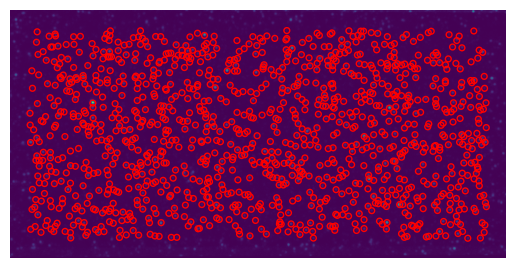

Please type y if threshold is good enough: y
deleted: [191.8304737   19.95018961]
deleted: [ 11.37345335 132.2338237 ]
deleted: [ 18.13868545 145.93052698]
deleted: [ 17.88946908 127.59033972]
deleted: [ 19.5780428  206.91784376]
deleted: [18.02634038 91.98720639]
deleted: [ 16.31148094 199.01809788]
deleted: [356.8104634  14.0591799]
deleted: [423.68768452  14.99941449]
deleted: [36.47851729 19.99048869]
deleted: [354.76345172  19.90356622]
deleted: [371.37566878  16.25466367]
deleted: [ 13.88389536 180.51904236]
deleted: [ 13.48744672 201.31510104]
deleted: [16.97252297 28.67496765]
deleted: [323.95302138  16.1490733 ]
deleted: [401.07877874  17.13447629]
deleted: [353.88386829  14.07694893]
deleted: [381.32715339  19.49162876]
deleted: [18.53374221 41.27721674]
deleted: [426.78369845  13.52308575]
deleted: [ 19.32149907 166.69922326]
deleted: [256.55678796  19.8796349 ]
deleted: [90.18421469 19.58480228]
deleted: [322.22906254  17.44484908]
deleted: [184.55724069  17.70392854]
delet

Working on frame 306
Working on frame 307
Working on frame 308
Working on frame 309
Working on frame 310
Working on frame 311
Working on frame 312
Working on frame 313
Working on frame 314
Working on frame 315
Working on frame 316
Working on frame 317
Working on frame 318
Working on frame 319
Working on frame 320
Working on frame 321
Working on frame 322
Working on frame 323
Working on frame 324
Working on frame 325
Working on frame 326
Working on frame 327
Working on frame 328
Working on frame 329
Working on frame 330
Working on frame 331
Working on frame 332
Working on frame 333
Working on frame 334
Working on frame 335
Working on frame 336
Working on frame 337
Working on frame 338
Working on frame 339
Working on frame 340
Working on frame 341
Working on frame 342
Working on frame 343
Working on frame 344
Working on frame 345
Working on frame 346
Working on frame 347
Working on frame 348
Working on frame 349
Working on frame 350
Working on frame 351
Working on frame 352
Working on fr

In [16]:
extract_traces(trans,reverse_trans)

In [14]:
print(CM_green)
print(CM_red)

NameError: name 'CM_green' is not defined

In [12]:
reverse_trans([[200,200]])

array([[207.44868672, 205.85306364]])

In [13]:
trans([[207.44868672, 205.85306364]])

array([[200.002347  , 200.02302915]])

Optimisation

In [ ]:
 for  j,coord in enumerate(CM_red):
                            x, y = coord
                            x0 = int(x-r)
                            x1 = int(x+r+1)
                            y0 = int(y-r)
                            y1 = int(y+r+1)
                            dx = x-x0
                            dy = y-y0

                            it = np.nditer(weights_red[j], flags=['multi_index'], op_flags=['readwrite'])
                            for w1 in it:
                                yt,xt = it.multi_index
                                w1[...] = 2*exp(-0.4*((xt-dx)**2+(yt-dy)**2))
                            it.close()

                            x, y = CM_green[j]
                            x0 = int(x-r)
                            x1 = int(x+r+1)
                            y0 = int(y-r)
                            y1 = int(y+r+1)
                            dx = x-x0
                            dy = y-y0
                            
                            it = np.nditer(weights_green[j], flags=['multi_index'], op_flags=['readwrite'])
                            for w1 in it:
                                yt,xt = it.multi_index
                                w1[...] = 2*exp(-0.4*((xt-dx)**2+(yt-dy)**2))
                            it.close()


In [38]:
CM_trans = tr_G2R(CM)